# Inspect Extracted Noise

We extract "noise" in the `seasonal-decomposition` step. 
Here we analyse it via a **scatter matrix** to inspect correlations with the features.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pathlib import Path

In [68]:
root = Path(r"..\data\us_cf1_fede")

df_noise = pd.read_pickle(root / "data\postprocessed" / "kc_noise.pickle").to_frame().reset_index()
df_noise.rename(columns={'resid': "Residual"}, inplace=True)
df_noise.index

RangeIndex(start=0, stop=1077, step=1)

## Scatter Plotting Noise

<AxesSubplot:>

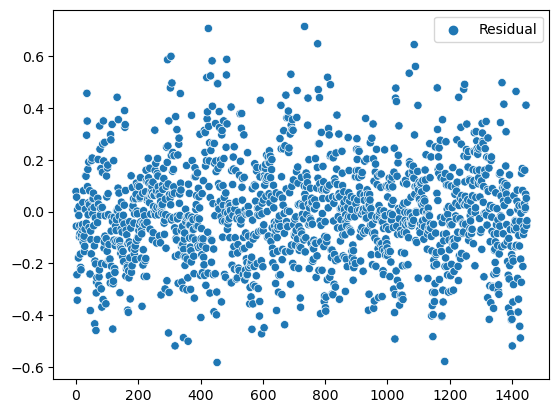

In [3]:
sns.scatterplot(df_noise)

### Noise colored by Day of Month

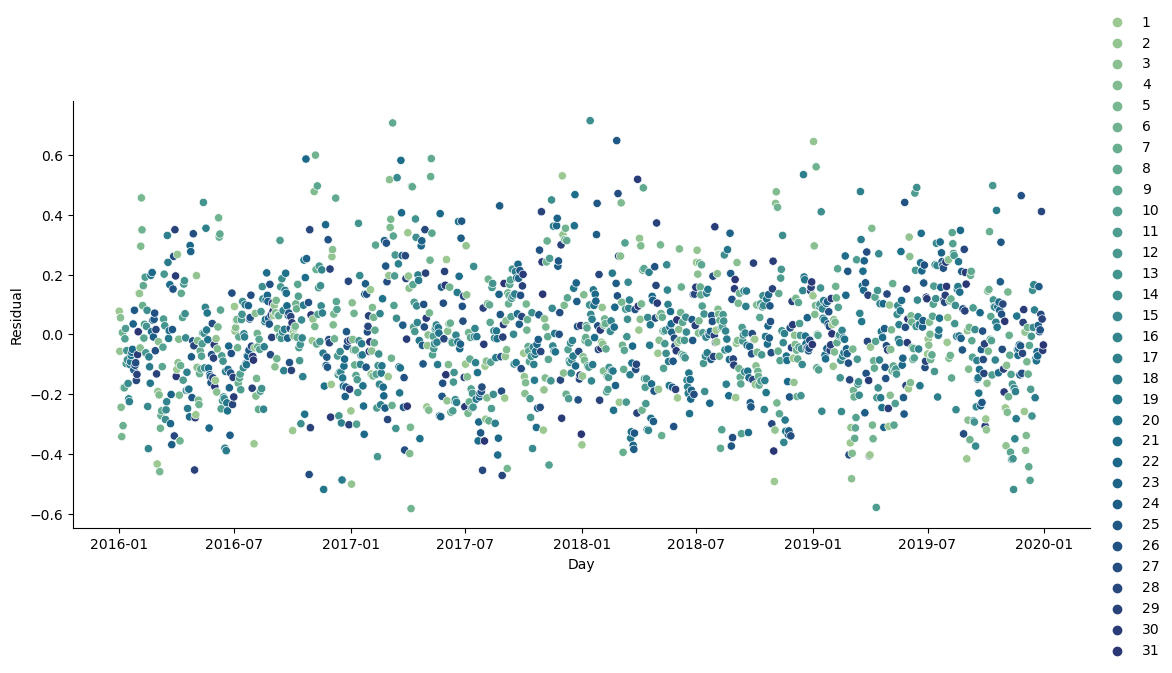

In [4]:
sns.relplot(df_noise, x="Day", y="Residual", kind="scatter", 
            hue=df_noise.apply(lambda x: str(x.loc["Day"].day), axis=1), palette="crest", 
            aspect=20/9)

*There is no evident pattern emerging from this figure, only that, **in Winter, values are more spread***.

## Correlation with Features

### Read Features Data

In [5]:
features_used = ["DOY", "Tmin", "Tmax", "Tdew", "Uwind", "Vwind", "Rs", "ETa"] 
df_fts = pd.read_pickle(root / "data/raw/data.pickle").loc[:, features_used].reset_index()
df_fts

,Day,DOY,Tmin,Tmax,Tdew,Uwind,Vwind,Rs,ETa
0,2016-01-01,1.0,268.424,271.022,266.299,4.371,1.060,4274972.0,NaN
1,2016-01-02,2.0,268.097,271.719,266.120,3.473,1.391,3272800.0,NaN
2,2016-01-03,3.0,266.913,271.987,267.221,3.825,-0.326,3968672.0,NaN
3,2016-01-04,4.0,256.742,266.049,256.240,-0.063,-2.721,8268880.0,NaN
4,2016-01-05,5.0,253.513,267.667,254.722,0.893,0.528,8281368.0,0.02
...,...,...,...,...,...,...,...,...,...
1456,2019-12-27,361.0,274.000,282.707,278.607,2.825,0.978,3044364.0,NaN
1457,2019-12-28,362.0,271.538,276.038,270.888,2.088,-0.264,7325324.0,NaN
1458,2019-12-29,363.0,272.189,273.939,271.491,-2.950,0.090,831244.0,NaN
1459,2019-12-30,364.0,273.383,278.973,273.851,-1.969,1.424,3530172.0,NaN


### Merge with Noise Data

pandas.core.series.Series

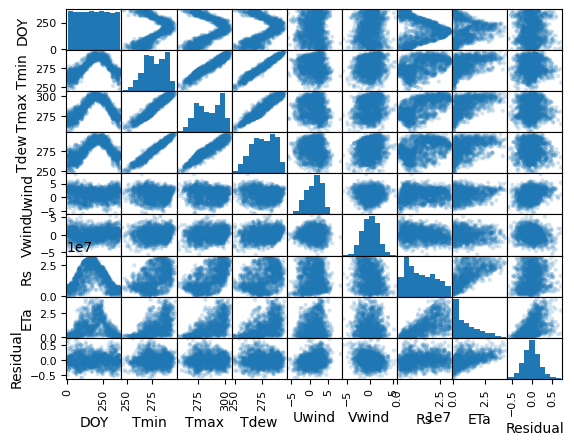

In [6]:
df = df_fts.merge(df_noise, on="Day")
pd.plotting.scatter_matrix(df, alpha=0.2)
type(df.corr(numeric_only=True)["Residual"])

### Plot Correlations

In [7]:
df_melted = df.melt(id_vars=["Residual"], var_name="Feature")
df_melted

,Residual,Feature,value
0,0.077933,Day,2016-01-01 00:00:00
1,-0.056306,Day,2016-01-02 00:00:00
2,0.056034,Day,2016-01-03 00:00:00
3,-0.243899,Day,2016-01-04 00:00:00
4,-0.342129,Day,2016-01-05 00:00:00
...,...,...,...
13036,0.067312,ETa,NaN
13037,0.411590,ETa,NaN
13038,0.051652,ETa,NaN
13039,-0.053111,ETa,NaN


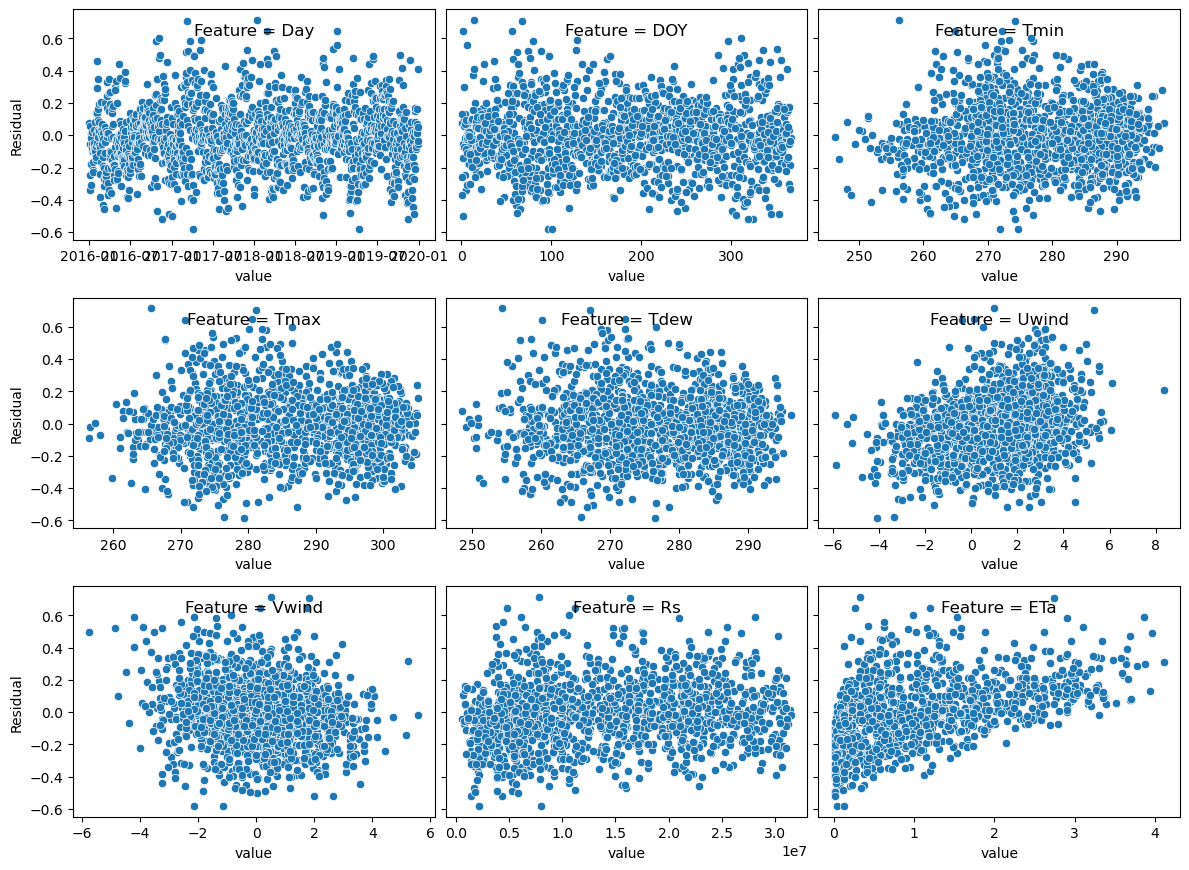

In [8]:
def plot_correlation(data, x, y):
    g = sns.relplot(data, x=x, y=y, 
                    col="Feature", col_wrap=3, 
                    facet_kws={"sharey":True, "sharex":False}, height=3, aspect=4/3)
    # for i, f in enumerate(features_used):
    #     g.axes[i].set_xlabel(f)

    # Draw lines for the upper and right sides of each axis
    for ax in g.axes.flat:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

    # Adjust the titles of each subplot
    for ax in g.axes.flat:
        ax.set_title(ax.get_title(), y=.85)  # Adjust the y value as needed

    g.figure.subplots_adjust(wspace=0.03)

    plt.show()
    return g

g = plot_correlation(df_melted, "value", "Residual")

## Probability Distribution Function

<AxesSubplot:title={'center':'Noise PDF'}, ylabel='Density'>

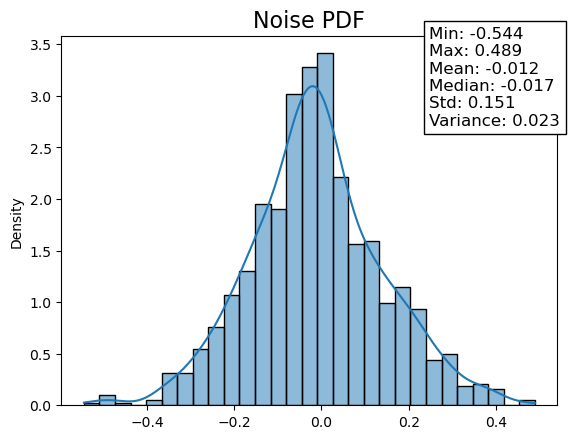

In [80]:
def get_statistics(data):
    minimum = data.min()
    maximum = data.max()
    mean = data.mean()
    median = data.median()
    std = data.std()
    var = data.var()  # Unbiased variance normalized by N-1
    statistics = pd.DataFrame(
        [minimum, maximum, mean, median, std, var],
        index = ["Min", "Max", "Mean", "Median", "Std", "Variance"],
    )
    stats_string = '\n'.join((
        f"Min: {minimum:.3f}",
        f"Max: {maximum:.3f}",
        f"Mean: {mean:.3f}",
        f"Median: {median:.3f}",
        f"Std: {std:.3f}",
        f"Variance: {var:.3f}",
    ))
    return stats_string, statistics
    

def plot_statistics(data, x=None, hue=None, statistics=None):
    if not x:
        g = sns.histplot(data, kde=True, stat="density", legend=False)
    else:
        g = sns.histplot(data, x=x, hue=hue, kde=True, stat="density", multiple="stack")
    
    g.set_title("Noise PDF", fontsize=16)
    if statistics:
        fig = g.figure
        boxprops = dict(ec='black', fc='white')
        g.figure.text(0.7, 0.9, statistics, 
                      fontsize=12, verticalalignment='top', bbox=boxprops)
    
    return g

statistics, csv = get_statistics(df_noise["Residual"])
csv.to_csv("kc_noise_Stats.csv", header=False)
plot_statistics(df_noise, statistics=statistics)